In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy
from desmin_reconstruction.plotting import clustered_scatterplot, line_and_bandplot
from desmin_reconstruction.preprocessing.bbox import BoundingSquare, filter_bounded
from desmin_reconstruction.preprocessing.storm import align_patch
from hdbscan import HDBSCAN
from jaxtyping import Float


df = pl.read_csv("../data/results/desmin_alphaactinin_600nm_filtered.csv")
out = df.partition_by("probe")

In [2]:
points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("desmin", "actinin"))
}
points["desmin"].shape

(59957, 3)

In [ ]:
def find_sarcomere_positions(
    points: Float[np.ndarray, "N 3"],
    num_spatial_bins: int = 100,
    min_peak_separation: float = 1.2,
    min_relative_prominance: float = 0.01,
):
    x = points[:, 0]
    counts, bins = np.histogram(x, bins=num_spatial_bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Find peaks with separation more than the known sarcomere length (~1.6um)
    peaks, _ = scipy.signal.find_peaks(
        counts,
        distance=min_peak_separation / (bin_centers[1] - bin_centers[0]),
        prominence=(len(x) * min_relative_prominance, None),
    )
    return bin_centers[peaks], (bin_centers, counts)


def nearest_sarcomere_distance(
    points: Float[np.ndarray, "N 3"],
    sarcomere_positions: Float[np.ndarray, " num_sarcomere"],
    normalize: bool = True,
):
    x = np.reshape(points[:, 0], (-1, 1))
    distances = np.min(np.abs(x - sarcomere_positions), axis=-1)

    if normalize:
        mean_sarcomere_length = np.mean(np.diff(sarco_pos))
        distances = distances / mean_sarcomere_length
    return distances

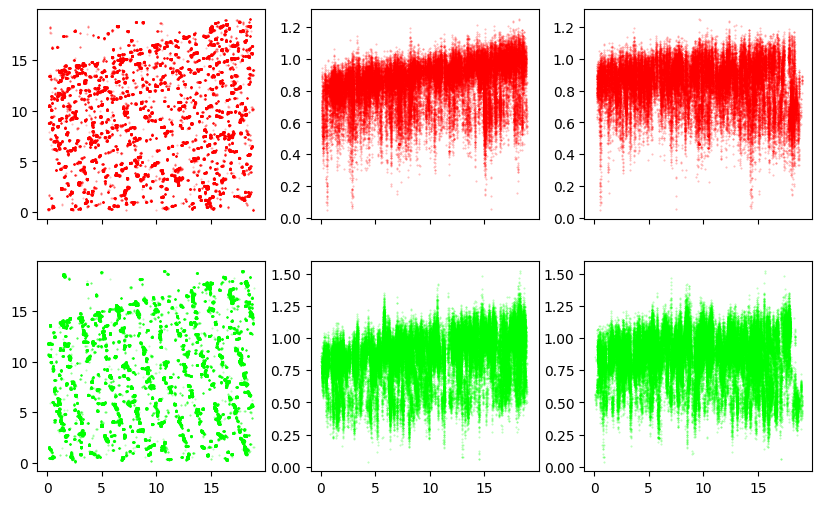

In [4]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True)
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            points[protein][:, ax1],
            points[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )


In [5]:
transform_fn, metrics = align_patch(
    points,
    tilt_sweep_values=np.arange(-2, 2, 0.001),
    rotation_sweep_values=np.arange(-15, 0, 0.1),
    min_cluster_size=200,
    min_samples=1,
)

  0%|          | 0/150 [00:00<?, ?it/s]/home/jhko725/Projects/ProteinStructureReconstruction.jl/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/Projects/ProteinStructureReconstruction.jl/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  1%|          | 1/150 [00:03<08:10,  3.29s/it]/home/jhko725/Projects/ProteinStructureReconstruction.jl/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/Projects/ProteinStructureReconstruction.jl/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed t

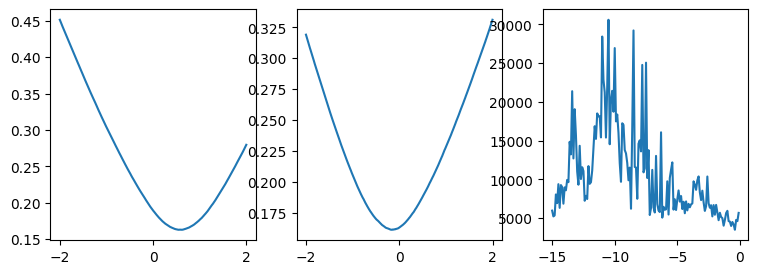

In [6]:
fig, axes = plt.subplots(1, len(metrics), figsize=(9, 3))
for ax, metric in zip(axes, metrics):
    ax.plot(*metric)

In [7]:
points_final = {k: transform_fn(v) for k, v in points.items()}

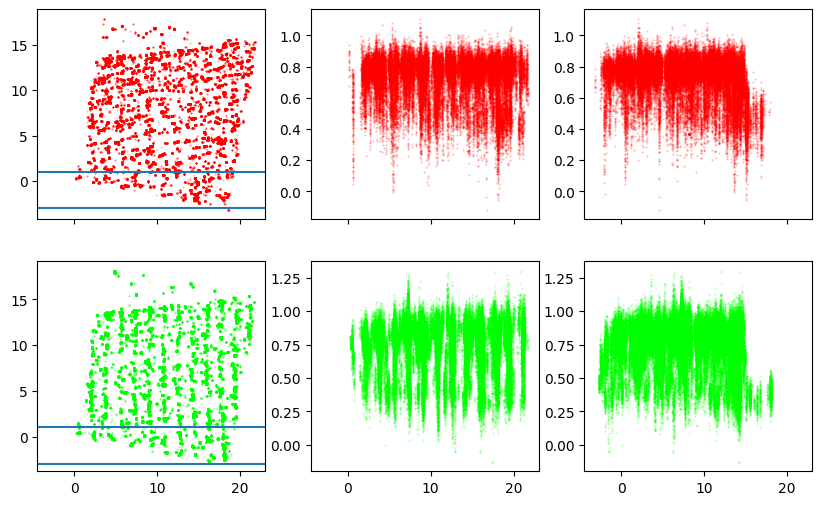

In [8]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True)
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            points_final[protein][:, ax1],
            points_final[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )
for ax in axes[:, 0]:
    ax.axhline(y=1)
    ax.axhline(y=-3)

In [9]:
x0s = (2, 6, 10, 14, 18, 1, 5, 9, 13, 17, 0, 4, 8, 12, 16, 15)
y0s = (9, 9, 9, 9, 9, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, -3)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

In [84]:
idx = 15
bbox = bboxes[idx]
sq1 = {k: filter_bounded(v, bbox) for k, v in points_final.items()}

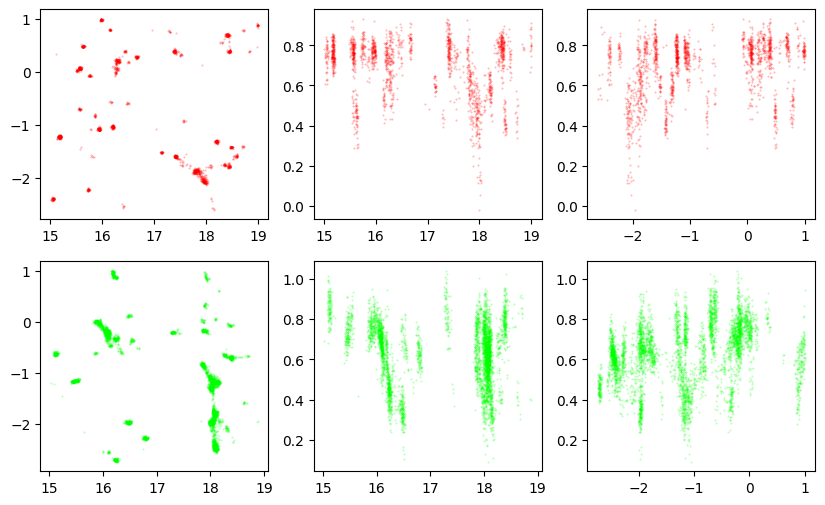

In [85]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq1[protein][:, ax1],
            sq1[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )


  0%|          | 0/80 [00:00<?, ?it/s]/home/jhko725/Projects/ProteinStructureReconstruction.jl/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/Projects/ProteinStructureReconstruction.jl/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/Projects/ProteinStructureReconstruction.jl/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/Projects/ProteinStructureReconstruction.jl/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed

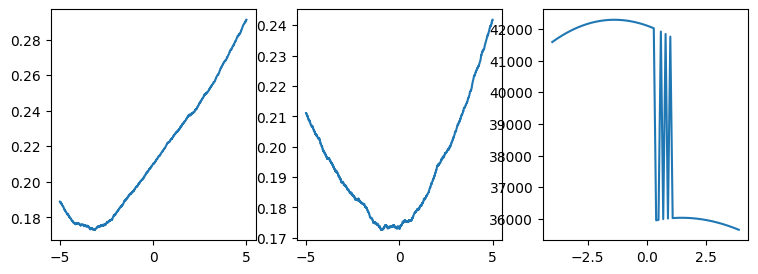

In [86]:
transform_fn_sq, metrics_sq = align_patch(
    sq1,
    tilt_sweep_values=np.arange(-5, 5, 0.001),
    rotation_sweep_values=np.arange(-4, 4, 0.1),
    min_cluster_size=500,
    min_samples=10,
)

fig, axes = plt.subplots(1, len(metrics_sq), figsize=(9, 3))
for ax, metric in zip(axes, metrics_sq):
    ax.plot(*metric)

/home/jhko725/Projects/ProteinStructureReconstruction.jl/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/Projects/ProteinStructureReconstruction.jl/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


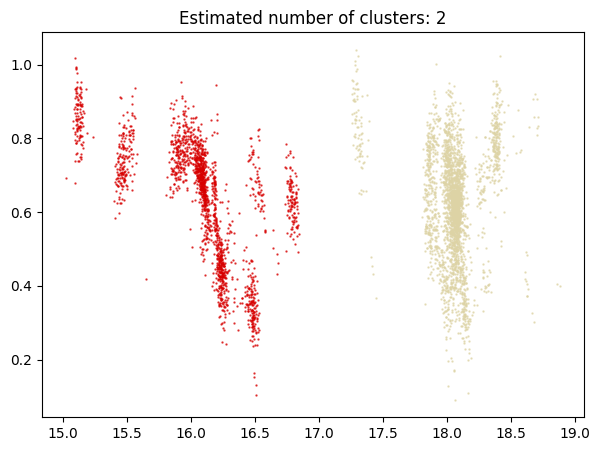

In [87]:
clusterer = HDBSCAN(min_cluster_size=500, min_samples=10)
xz = sq1["actinin"][:, np.array([0, 2])]
clusterer.fit(xz)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax = clustered_scatterplot(ax, xz, clusterer.labels_)

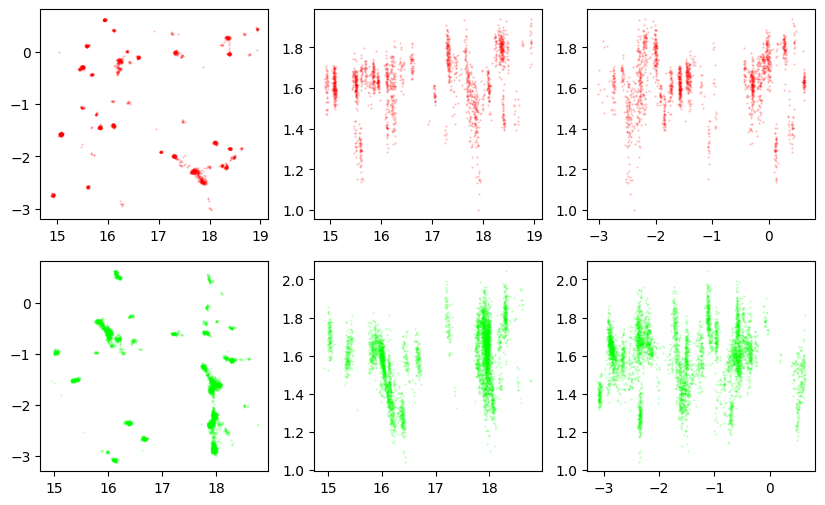

In [88]:
sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq1_final[protein][:, ax1],
            sq1_final[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )


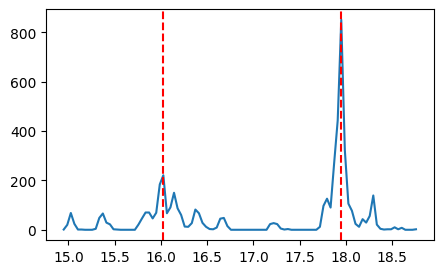

In [89]:
sarco_pos, distribution = find_sarcomere_positions(sq1_final["actinin"])
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(*distribution)
for pos in sarco_pos:
    ax.axvline(pos, ls="--", color="red")

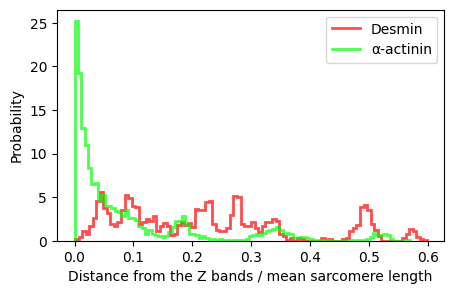

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sq_sarco_dists = {
    k: nearest_sarcomere_distance(v, sarco_pos) for k, v in sq1_final.items()
}


LABEL_DICT = {"desmin": "Desmin", "actinin": "α-actinin"}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
for name, dist in sq_sarco_dists.items():
    ax.stairs(
        *np.histogram(
            dist,
            bins=100,
            density=True,
        ),
        alpha=0.7,
        linewidth=2.0,
        color=COLOR_DICT[name],
        label=LABEL_DICT[name],
    )

ax.set_xlabel("Distance from the Z bands / mean sarcomere length")
ax.set_ylabel("Probability")
# ax.set_xlim((-0.02, 0.52))
ax.legend()

In [102]:
from tqdm import tqdm


sarcomere_distances = []
for roi in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, roi) for k, v in points_final.items()}
    transform_fn_sq, _ = align_patch(
        sq1,
        tilt_sweep_values=np.arange(-5, 5, 0.001),
        rotation_sweep_values=np.arange(-4, 4, 0.1),
        min_cluster_size=500,
        min_samples=10,
    )
    sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}
    sarco_pos, _ = find_sarcomere_positions(sq1_final["actinin"])
    sq_sarco_dists = {
        k: nearest_sarcomere_distance(v, sarco_pos) for k, v in sq1_final.items()
    }
    sarcomere_distances.append(sq_sarco_dists)

100%|██████████| 10000/10000 [00:02<00:00, 3457.86it/s]
/home/jhko725/Projects/ProteinStructureReconstruction.jl/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/Projects/ProteinStructureReconstruction.jl/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/Projects/ProteinStructureReconstruction.jl/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/Projects/ProteinStructureReconstruction.jl/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

In [103]:
dist_bins = np.linspace(0, 1.0, 200)
hist_counts = {
    k: [
        np.histogram(dist_dict[k], bins=dist_bins, density=True)[0]
        for dist_dict in sarcomere_distances
    ]
    for k in ("desmin", "actinin")
}
hist_counts["desmin"]

[array([1.57677596, 1.90300546, 2.01174863, 2.66420765, 2.66420765,
        1.68551913, 1.7942623 , 1.46803279, 1.7942623 , 2.17486339,
        1.73989071, 2.77295082, 2.88169399, 2.99043716, 2.66420765,
        3.09918033, 2.60983607, 2.77295082, 2.77295082, 2.66420765,
        2.44672131, 4.45846995, 3.26229508, 2.22923497, 2.17486339,
        2.17486339, 2.22923497, 1.46803279, 1.95737705, 1.57677596,
        0.81557377, 0.65245902, 0.92431694, 0.48934426, 0.92431694,
        0.7068306 , 0.65245902, 1.35928962, 1.35928962, 2.44672131,
        3.15355191, 2.55546448, 2.88169399, 3.26229508, 3.42540984,
        2.77295082, 3.15355191, 3.96912568, 2.99043716, 2.01174863,
        1.7942623 , 1.4136612 , 1.35928962, 2.01174863, 3.2079235 ,
        2.44672131, 3.64289617, 4.83907104, 3.86038251, 4.02349727,
        3.47978142, 2.60983607, 2.17486339, 2.33797814, 1.95737705,
        2.1204918 , 2.1204918 , 1.90300546, 1.84863388, 2.1204918 ,
        2.17486339, 2.28360656, 2.28360656, 1.73

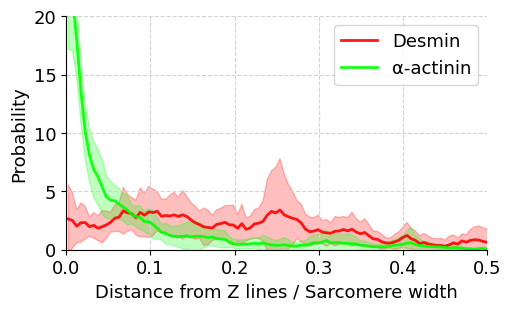

In [ ]:
plt.rc("font", size=13)
fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
for protein, distances in hist_counts.items():
    ax = line_and_bandplot(
        ax,
        (dist_bins[:-1] + dist_bins[1:]) / 2,
        np.mean(distances, axis=0),
        np.std(distances, axis=0),
        color=COLOR_DICT[protein],
        label=LABEL_DICT[protein],
        linewidth=2.0,
        alpha=0.9,
        alpha_band=0.25,
    )
ax.set_xlim((0, 0.5))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(ls="--", color="lightgray")
ax.set_xlabel("Distance from Z lines / Sarcomere width")
ax.set_ylabel("Probability")
ax.legend(loc="upper right")
ax.set_ylim((0, 20))
fig.savefig("../figures/fig_2/2d.svg", dpi=500)